In [1]:
import pickle as pkl
from pathlib import Path

import interfere
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm


DATADIR = "/work/users/d/j/djpassey/interfere_exp1/"

In [2]:
# Collect files from finished jobs
out_file_names = [DATADIR + f"exp1_output{i}.pkl" for i in range(294)]
out_file_paths = [Path(fname) for fname in out_file_names]
started_jobs = [p for p in out_file_paths if p.exists()]

In [15]:
len(started_jobs)

253

In [3]:
def is_stochastic(output_dict):
    """Checks if experiment has a non-zero noise term.
    """
    sigma = output_dict["model_params"].get("sigma", False)
    Sigma = output_dict["model_params"].get("Sigma", False)
    
    if isinstance(sigma, bool) and isinstance(Sigma, bool):
        return False
        
    total_size = np.sum(sigma) + np.sum(Sigma)
    return total_size > 0


### Construct a dictionary for data analysis

In [4]:
analysis_dict = {
    "dynamics": [],
    "stochastic": [],
    "inference_method": [],
    "directional_acc": [],
    "mean_squared_err": []
}

## Load and score data from all finished experiments

In [5]:
# Initialize metrics
direction_metric = interfere.benchmarking.DirectionalChangeBinary()
error_metric = interfere.benchmarking.RootMeanStandardizedSquaredError()

In [6]:
for fname in started_jobs:
    # Load the result of a single experiment
    with open(fname, "rb") as fstream:
        output = pkl.load(fstream)
    
    # Grab which dynamic model was used
    dynamics = output["model_type"].__name__
    
    # Check if model was stochastic
    stochastic = is_stochastic(output)
    
    # Grab the indexes that were intervened
    intervened_idxs = output["intervention_params"]["intervened_idxs"]
    
    if "method_results" in output:
        # Grab the training data
        Xs = output["Xs"]
        
        # Grab the true interventions
        X_dos = output["X_dos"]
        all_methods = output["method_results"]
        
        for method_result_list in all_methods:
            # Unfortunately only the last instance was saved :(
            X = Xs[-1]
            X_true = X_dos[-1]
                
            # Save the name of the method
            inference_method = method_result_list["method_type"].__name__

            for X_pred in method_result_list["X_do_pred"]:

                # If the prediction is not the same shape as the truth --
                # Extend the prediction array by repeating the last row.
                m, _ = X_true.shape
                m_pred, _ = X_pred.shape
                if m != m_pred:
                    X_pred = np.vstack([X_pred] + [X_pred[-1, :] for i in range(m - m_pred)])
                    
                # Measure accuracy and error
                directional_acc = direction_metric(X, X_true, X_pred, intervened_idxs)
                mean_squared_err = error_metric(X, X_true, X_pred, intervened_idxs)

                # Store data
                analysis_dict["dynamics"].append(dynamics)
                analysis_dict["stochastic"].append(stochastic)
                analysis_dict["inference_method"].append(inference_method)
                analysis_dict["directional_acc"].append(directional_acc)
                analysis_dict["mean_squared_err"].append(mean_squared_err)


In [7]:
len(analysis_dict["dynamics"])

180

In [8]:
df = pd.DataFrame(analysis_dict)
df = df.astype(
    {
        "dynamics": "category",
        "stochastic": bool,
        "inference_method": "category",
        "directional_acc": float,
        "mean_squared_err": float

    }
)

df["group"] = 1  

vcf = {
    "dynamics": "0 + C(dynamics)", "inference_method": "0 + C(inference_method)"
}

df_no_outlier = df[df["mean_squared_err"] < 100]


model = sm.MixedLM.from_formula(
    "mean_squared_err ~ stochastic",
    groups="group",
    vc_formula=vcf,
    re_formula="0",
    data=df_no_outlier
)                                                   
result = model.fit() 

In [9]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:             MixedLM Dependent Variable: mean_squared_err
No. Observations:  172     Method:             REML            
No. Groups:        1       Scale:              73.4362         
Min. group size:   172     Log-Likelihood:     -623.1734       
Max. group size:   172     Converged:          Yes             
Mean group size:   172.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             9.349    3.653  2.559 0.010  2.188 16.509
stochastic[T.True]   -3.651    1.400 -2.607 0.009 -6.395 -0.906
dynamics Var         51.583    3.469                           
inference_method Var 18.894    2.416                           
===============================================================

"""

In [10]:
df.iloc[np.random.permutation(180)[:5], :]

,dynamics,stochastic,inference_method,directional_acc,mean_squared_err,group
7,coupled_logistic_map,True,VAR,0.777778,0.851691,1
20,coupled_logistic_map,False,VAR,0.444444,1.446579,1
137,coupled_map_1dlattice_spatiotemp_intermit1,True,VAR,0.888889,2.697204,1
44,coupled_logistic_map,False,LTSFLinearForecaster,0.111111,108.064794,1
47,coupled_logistic_map,True,VAR,0.666667,0.405088,1


In [11]:
df_no_outlier["stochastic"].value_counts()

stochastic
True     87
False    85
Name: count, dtype: int64

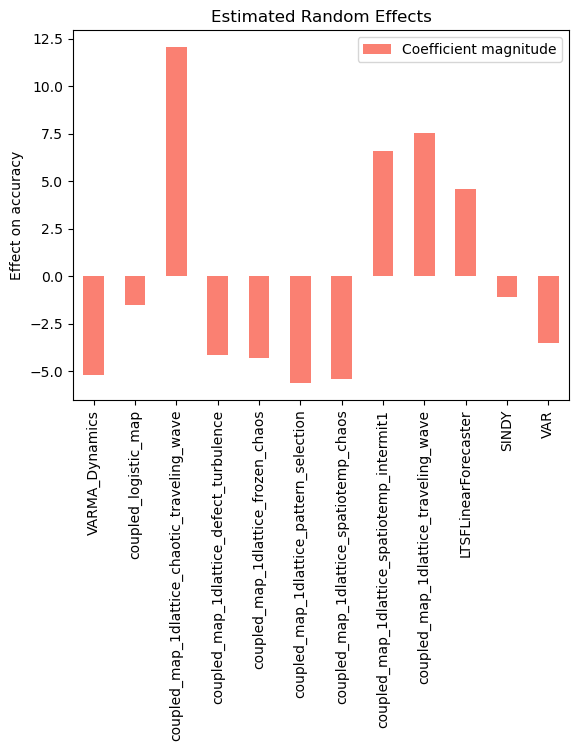

In [12]:
reff_index = [
    k[:-2].split("[")[-1]

    for k in result.random_effects[1].keys().values
]

coefs = result.random_effects[1].values

reff_df = pd.DataFrame(coefs, index=reff_index, columns=["Coefficient magnitude"])

reff_df.plot.bar(
    color="salmon",
    label="Effect on accuracy",
)
plt.ylabel("Effect on accuracy")
plt.title("Estimated Random Effects")
plt.show()

In [13]:
colors = ["r", "b", "k", "g", "pink", "orange", "teal", "salmon", "magenta"]
dyn_color_dict = {
    d:c for c, d in zip(colors, df["dynamics"].unique())
}
dyn_color_series = [dyn_color_dict[d] for d in df["dynamics"]]
df["dyn_colors"] = dyn_color_series
df["log_mse"] = np.log(df["mean_squared_err"])



172


NameError: name 'color_dict' is not defined

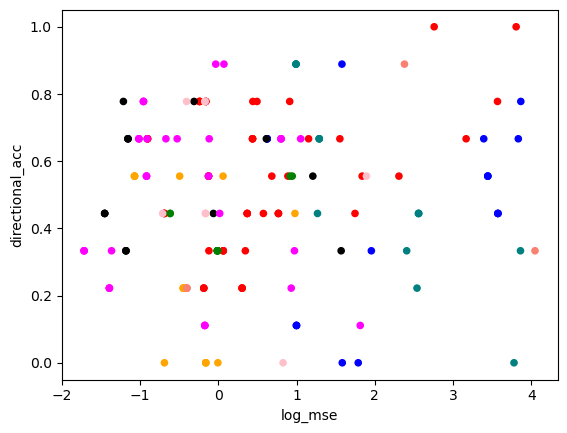

In [14]:
df_no_outlier = df[df["mean_squared_err"] < 100]
df_no_outlier.plot.scatter("log_mse", "directional_acc", c="dyn_colors")
print(len(df_no_outlier))
print(color_dict)